In [ ]:
# | hide
# from chewc.core import *
# from chewc.pop import *
# from chewc.sp import *
# from chewc.trait import *

# chewc

> JAX breeding sim

## Developer Guide

If you are new to using `nbdev` here are some useful pointers to get you started.

### Install chewc in Development mode

```sh
# make sure chewc package is installed in development mode
$ pip install -e .

# make changes under nbs/ directory
# ...

# compile to have changes apply to chewc
$ nbdev_prepare
```

## Usage

### Installation

Install latest from the GitHub [repository][repo]:

```sh
$ pip install git+https://github.com/cjGO/chewc.git
```


[repo]: https://github.com/cjGO/chewc
[docs]: https://cjGO.github.io/chewc/
[pypi]: https://pypi.org/project/chewc/
[conda]: https://anaconda.org/cjGO/chewc

### Documentation

Documentation can be found hosted on this GitHub [repository][repo]'s [pages][docs].

[repo]: https://github.com/cjGO/chewc
[docs]: https://cjGO.github.io/chewc/

## How to use

In [ ]:
import jax
import jax.numpy as jnp
import time

# --- 1. JAX Setup ---
key = jax.random.PRNGKey(42)

# --- 2. Imports from the 'chewc' library ---
# Note the cleaner imports: we only need high-level components now.
from chewc.sp import SimParam
from chewc.population import Population, quick_haplo
from chewc.trait import add_trait_a
from chewc.burnin import run_burnin # Import the new burn-in function

# --- 3. Define Genome Blueprint ---
n_chr, n_loci_per_chr, ploidy = 3, 100, 2
gen_map = jnp.array([jnp.linspace(0, 1, n_loci_per_chr) for _ in range(n_chr)])
centromeres = jnp.full(n_chr, 0.5)

# --- 4. Define Trait Architecture ---
trait_mean = 0.0
trait_var = 1.0
trait_h2 = 0.1

# --- 5. Define Burn-in Parameters ---
n_parents_select = 6
n_progeny = 20
burn_in_generations = 5

# --- 6. Instantiate SimParam ---
sp = SimParam(gen_map=gen_map, centromere=centromeres, ploidy=ploidy)

# --- 7. Create Founder Population ---
key, pop_key = jax.random.split(key)
founder_pop = quick_haplo(key=pop_key, sim_param=sp, n_ind=10, inbred=False)
sp = sp.replace(founderPop=founder_pop)

# --- 8. Add Trait to SimParam ---
key, trait_key = jax.random.split(key)
sp = add_trait_a(
    key=trait_key,
    sim_param=sp,
    n_qtl_per_chr=100,
    mean=jnp.array([trait_mean]),
    var=jnp.array([trait_var])
)

# --- 9. Run the entire Burn-in Phase with a single function call ---
key, burnin_key = jax.random.split(key)
h2 = jnp.array([trait_h2])

start_time = time.time()
# The call to run_burnin encapsulates the entire loop, including initial
# phenotyping and JIT compilation on the first internal generation.
final_pop = run_burnin(
    key=burnin_key,
    sp=sp,
    n_generations=burn_in_generations,
    n_parents=n_parents_select,
    n_progeny=n_progeny,
    h2=h2,
    verbose=True # This will print the progress per generation
)
# Ensure all JAX computations are finished before stopping the timer
final_pop.geno.block_until_ready()
end_time = time.time()

# --- 10. Report Results ---
total_time = end_time - start_time
avg_time_per_gen = total_time / burn_in_generations

print("-" * 50)
print(f"Total simulation time for burn-in: {total_time:.4f} seconds.")
print(f"Average time per generation (including compilation): {avg_time_per_gen * 1000:.4f} ms")
print(f"\nFinal population state after {burn_in_generations} generations:")
print(final_pop)

--- Starting Accelerated Burn-in (5 Generations) ---
Generation  1/5 | Mean Phenotype: 0.4416
Generation  2/5 | Mean Phenotype: 0.5609
Generation  3/5 | Mean Phenotype: 0.9808
Generation  4/5 | Mean Phenotype: 1.6960
Generation  5/5 | Mean Phenotype: 1.9740

--- Burn-in Complete ---
--------------------------------------------------
Total simulation time for burn-in: 0.1863 seconds.
Average time per generation (including compilation): 37.2615 ms

Final population state after 5 generations:
Population(nInd=20, nTraits=1, has_ebv=No)


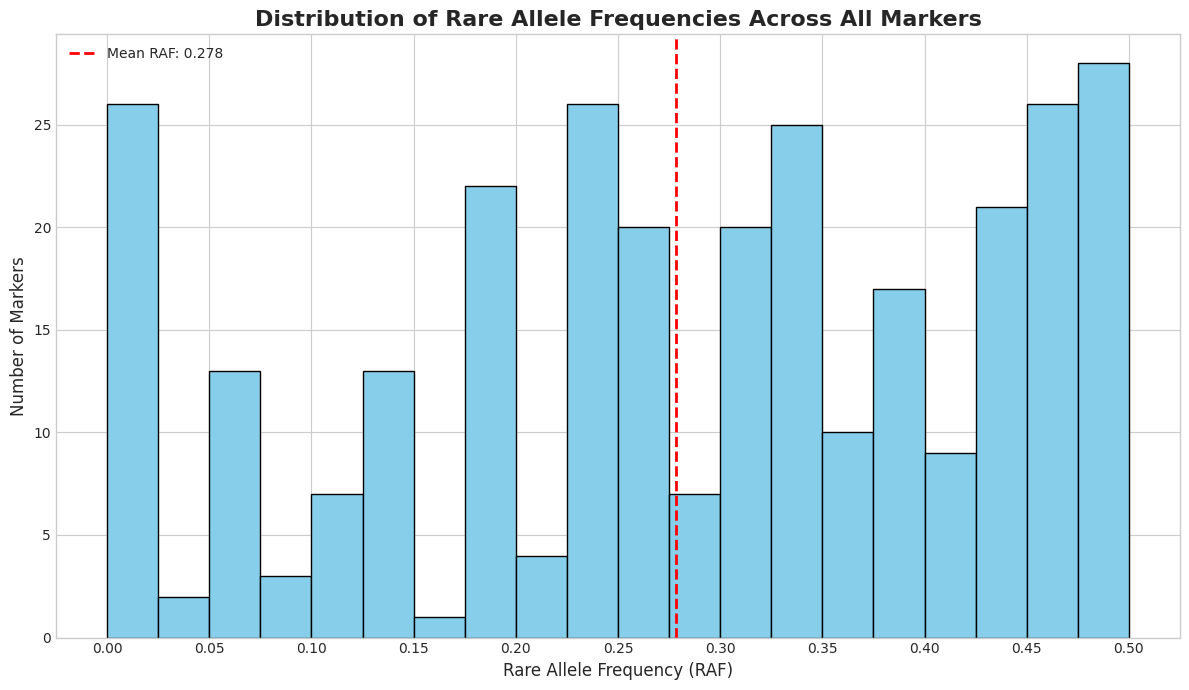

Shape of the summary array: (3, 100)
Shape of the flattened array for plotting: (300,)
Mean Rare Allele Frequency: 0.2784999907016754
Min Frequency: 0.0
Max Frequency: 0.5
Shape of the input data: (20, 3, 2, 100)
Shape of the final summary array: (3, 100)

Example: Proportions for the first 5 markers on the first chromosome:
[0.19999999 0.025      0.3        0.05000001 0.         0.
 0.         0.5        0.07499999 0.4        0.17500001 0.19999999
 0.4        0.         0.325      0.         0.325      0.2
 0.39999998 0.075      0.27499998 0.375      0.375      0.325
 0.425      0.22500002 0.22500002 0.05       0.275      0.275
 0.22500002 0.275      0.         0.         0.05000001 0.225
 0.225      0.05000001 0.22500002 0.05000001 0.2        0.25
 0.425      0.02499998 0.17500001 0.025      0.19999999 0.
 0.475      0.175      0.35000002 0.225      0.225      0.25
 0.02499998 0.475      0.25       0.39999998 0.375      0.02499998
 0.325      0.4        0.425      0.3        0.3     

In [ ]:
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import numpy as np

# 1. Simulate your data array
# This creates a random array with the specified dimensions to demonstrate the logic.
# Shape: (individuals, chromosomes, haplotypes, markers)
key = random.PRNGKey(42)
def calculate_rare_allele_frequency(data):
  """
  Calculates the proportion of the rare allele for each marker per chromosome.

  Args:
    data: A jnp.ndarray with shape (individuals, chromosomes, haplotypes, markers).

  Returns:
    A jnp.ndarray with shape (chromosomes, markers) containing the rare allele proportions.
  """
  # Total alleles per marker = number of individuals * number of haplotypes
  total_alleles = data.shape[0] * data.shape[2] # 100 * 2 = 200

  # Sum over the 'individuals' (axis 0) and 'haplotypes' (axis 2) dimensions.
  allele_1_counts = data.sum(axis=(0, 2))

  # Calculate the frequency (proportion) of allele '1'.
  p = allele_1_counts / total_alleles

  # The rare allele is the one with a frequency < 0.5.
  rare_allele_proportions = jnp.minimum(p, 1 - p)

  return rare_allele_proportions

# Get the (3, 100) summary array
rare_allele_summary = calculate_rare_allele_frequency(final_pop.geno)


# --- 2. Visualize the Frequencies as a Histogram ---

# Flatten the (3, 100) array into a 1D array of 300 values
# Convert to a standard NumPy array for plotting
frequencies_flat = np.array(rare_allele_summary.flatten())

# Create the histogram
plt.style.use('seaborn-v0_8-whitegrid') # Use a nice style for the plot
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the histogram with 20 bins for good resolution
# The range is [0, 0.5] since these are rare allele frequencies
ax.hist(frequencies_flat, bins=20, range=(0, 0.5), color='skyblue', edgecolor='black')

# Set titles and labels for clarity
ax.set_title('Distribution of Rare Allele Frequencies Across All Markers', fontsize=16, fontweight='bold')
ax.set_xlabel('Rare Allele Frequency (RAF)', fontsize=12)
ax.set_ylabel('Number of Markers', fontsize=12)

# Set x-axis ticks for better readability
ax.set_xticks(np.arange(0, 0.51, 0.05))

# Add a vertical line at the mean RAF
mean_raf = frequencies_flat.mean()
ax.axvline(mean_raf, color='red', linestyle='--', linewidth=2, label=f'Mean RAF: {mean_raf:.3f}')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

# --- Verification ---
print(f"Shape of the summary array: {rare_allele_summary.shape}")
print(f"Shape of the flattened array for plotting: {frequencies_flat.shape}")
print(f"Mean Rare Allele Frequency: {mean_raf}")
print(f"Min Frequency: {frequencies_flat.min()}")
print(f"Max Frequency: {frequencies_flat.max()}")

# 3. Get the final result
rare_allele_summary = calculate_rare_allele_frequency(final_pop.geno)

# --- Verification ---
print(f"Shape of the input data: {final_pop.geno.shape}")
print(f"Shape of the final summary array: {rare_allele_summary.shape}")
print("\nExample: Proportions for the first 5 markers on the first chromosome:")
print(rare_allele_summary[1, :100])